# Using dependent Dirichlet weights to analyze correlated time series

Summary:
- Using weights from a Dirichlet distribution to compute errors on a correlated time series lead to underestimation of errors
- Using weights from a dependent Dirichlet distribution leads to errors compatible with those obtained with block analysis, thus correctly considering correlations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba

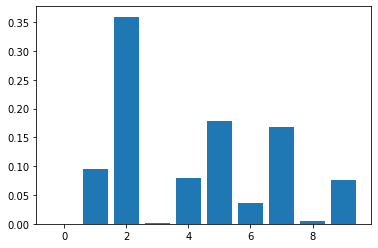

In [95]:
M=10

b=[]
for i in range(1):#000):
    a=np.random.dirichlet(1/2*np.ones(M))
    plt.bar(np.arange(M),a)
    b.append(a)

#b=np.array(b)
#plt.figure()
#plt.hist(np.array(b))

In [2]:
# tool to compute autocorrelation function of a time series using FFT
def autocorr(x):
    r2=np.fft.ifft(np.abs(np.fft.fft(x))**2).real
    c=(r2/x.shape-np.mean(x)**2)/np.std(x)**2
    return c[:len(x)//2]

In [3]:
# tool to generate a correlated time series
# size Gaussian numbers with zero average, unitary variance
# and autocorrelation time tau steps
@numba.jit
def _autocorrelated_series(series,tau):
    c1=np.exp(-1.0/tau)
    c2=np.sqrt(1.0-c1*c1)
    for i in range(len(series)-1):
        series[i+1]=c1*series[i]+c2*series[i+1]
def autocorrelated_series(size,tau):
    timeseries=np.random.normal(size=size)
    _autocorrelated_series(timeseries,tau)
    return timeseries

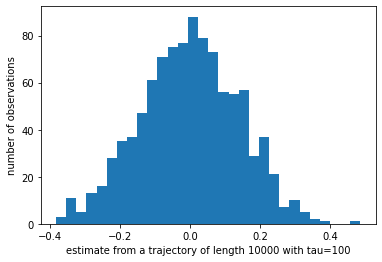

In [4]:
# for instance, if we generate a trajectory of length 10000 with tau=100
# we expect an error^2=2*sigma^2*tau/length
averages=[]
for i in range(1000):
    series=autocorrelated_series(10000,tau=100.0)
    averages.append(np.average(series))
averages=np.array(averages)
plt.hist(averages,bins=30)
plt.xlabel("estimate from a trajectory of length 10000 with tau=100")
plt.ylabel("number of observations")
plt.show()

In [5]:
print("expected error:",np.sqrt(2*100/10000))
print("actual error:",np.sqrt(np.average(averages**2)))

expected error: 0.1414213562373095
actual error: 0.13984656125107398


## Reference time series

We then generate a reference time series. I do it once so that the same exact series is analyzed in different ways.

I generate a series with 10000 frames and autocorrelation time 100.

In [7]:
np.random.seed(1977)
series=autocorrelated_series(10000,100.0)

I check if the autocorrelation function is how I expect:

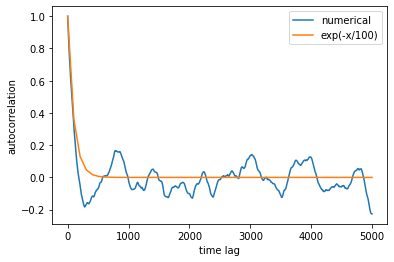

In [8]:
plt.plot(autocorr(series),label="numerical")
x=np.linspace(0.0,len(series)//2)
plt.plot(x,np.exp(-x/100.0),label="exp(-x/100)")
plt.xlabel("time lag")
plt.ylabel("autocorrelation")
plt.legend()
plt.show()

Notice that they agree only in the initial decay.

## Block analysis

I now do a standard block analysis, as a reference. 

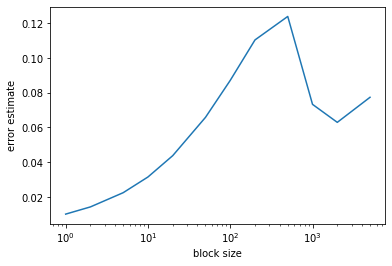

In [9]:
block_sizes=(1,2,5,10,20,50,100,200,500,1000,2000,5000)
error=[]
for block_size in block_sizes:
    block_averages=(np.average(series.reshape((-1,block_size)),axis=1))
    error.append(np.std(block_averages)/np.sqrt(len(series)/block_size))
plt.plot(block_sizes,error)
plt.xscale("log")
plt.xlabel("block size")
plt.ylabel("error estimate")
plt.show()

Notice that there's not a real plateu. This is expected, since our trajectory is just as long as 10 correlation times. By trying with a longer trajectory we can obtain a plateu.

Actually, one can compute exactly how the error estimate as a function of the block length should look like if the autocorrelation function is known. This can shown to be exactly:
\begin{equation}
\epsilon = \frac{2 \sigma^2}{L} \sum_{i=0}^{B_s}f(i)\left(1-\frac{i}{B_s}\right)
\end{equation}

For this trajectory, we can compare the error as a function of the block size computed in three different ways:
- with the block analysis (as above)
- with the exact expression base on the empirical autocorrelation function
- with the exact expression base on the known autocorrelation function

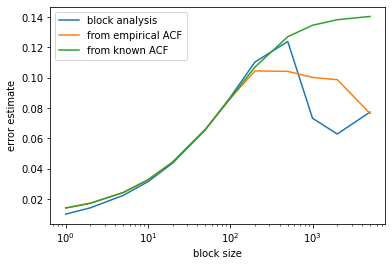

In [10]:
ac=autocorr(series)
errors1=[]
errors2=[]
for block_size in block_sizes:
    error1=np.sqrt(2/len(series)*np.sum(ac[:block_size]*(1-np.arange(block_size)/block_size)))
    errors1.append(error1)
    error2=np.sqrt(2/len(series)*np.sum(np.exp(-np.arange(block_size)/100)*(1-np.arange(block_size)/block_size)))
    errors2.append(error2)
plt.plot(block_sizes,error,label="block analysis")
plt.plot(block_sizes,errors1,label="from empirical ACF")
plt.plot(block_sizes,errors2,label="from known ACF")
plt.xscale("log")
plt.xlabel("block size")
plt.ylabel("error estimate")
plt.legend()
plt.show()

They agree well in the regime where they are statistically significant (small block size), and have noise when there are too few blocks

## Estimating errors with Dirichlet prior

We then try to estimate errors using a Dirichlet prior on weights. This assumes that data are not correlated (which we know not to be true) and should thus underestimate the error. Notice that this is exactly the same as doing so-called Bayesian bootstrap.

In [11]:
# sample 200 times from weights according to the dirichlet distribution
weights=np.random.dirichlet(np.ones(len(series)),size=200)
# compute stddev of the result
np.std(np.matmul(weights,series))

0.009396557817303525

This is indeed much smaller than the expected error 0.1414213562373095

We can see the same problem in a slightly different way. Let's say that we repeat our bootstrap doing a subsample of the trajectory with a given stride. With a small stride, the error should be underestimated (samples are assumed independent but they are not). With a large stride, error estimate should be fine. However, the error itself will be larger, because we are discarding data.

In [12]:
skips=(1,2,5,10,20,50,100,200,500,1000,2000)
averages=[]
stddevs=[]
for skip in skips:
    # construct skipped timeseries
    s=series[::skip]
    # sample 2000 times from weights according to the dirichlet distribution
    weights=np.random.dirichlet(np.ones(len(s)),size=200)
    # compute stddev of the result
    stddev=np.std(np.matmul(weights,s))
    # for comparison, we also compute the average along the skipped timeseries
    average=np.average(s)
    averages.append(average)
    stddevs.append(stddev)

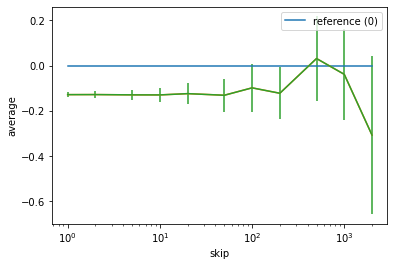

In [13]:
plt.plot(skips,np.zeros(len(skips)),label="reference (0)")
plt.plot(skips,averages)
plt.errorbar(skips,averages,stddevs)
plt.xscale("log")
plt.xlabel("skip")
plt.ylabel("average")
plt.legend()
plt.show()

Results are as expected.

The issue here is that weights drawn from the Dirichlet distribution are independent (except for normalization), so the information about the time correlation between samples from the trajectory is lost. Ideally, I would like to draw **correlated** numbers from the Dirichlet distribution.

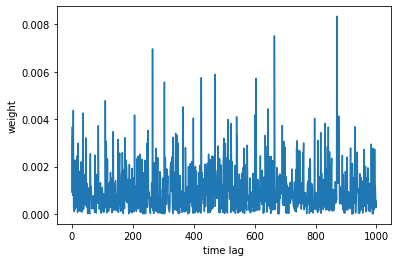

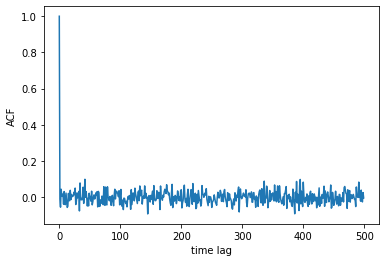

In [14]:
weights=np.random.dirichlet(np.ones(1000),1).flatten()
plt.plot(weights)
plt.xlabel("time lag")
plt.ylabel("weight")
plt.show()
plt.plot(autocorr(weights))
plt.xlabel("time lag")
plt.ylabel("ACF")
plt.show()

## How to generate correlated Dirichlet numbers

This is fuzzy, but kind of works....

Dirichlet numbers can be drawn with the following procedure

(see https://en.wikipedia.org/wiki/Dependent_Dirichlet_process)

- Draw N numbers from a $\Gamma(\alpha,1)$, call them $y_i$. That is: $P(y)\propto y^{\alpha-1}\exp(-y)$.
- Define $x_i=\frac{y_i}{\sum_i y_i}$

If I draw $M$ normalized Gaussian number ($R_i$) and compute $y=\frac{\sum_{i=1}^MR_i^2}{2}$, then $P(y)\propto y^{\frac{M}{2}-1} e^{-y}$ (notice that this is the same distribution of the kinetic energy in the canonical ensemble at k_BT=1).

In this specific case, I am interested in generating numbers from a Dirichlet distribution with $\alpha=1$. I can just draw pairs ($M=2$) of Gaussian numbers then.

In other words, I can generate size samples from the Dirichlet distribution with $\alpha=1$ as follows:

In [15]:
def my_dirichlet(N,size):
    R=np.random.normal(size=(size,N,2))
    R=np.sum(0.5*R**2,axis=2) # 0.5*(R1**2+R2**2)
    R/=np.sum(R,axis=1)[:,np.newaxis] # normalize
    return R

Let's check correlations first

(10000,)


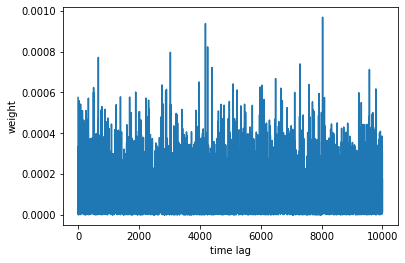

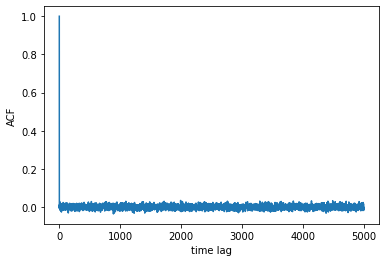

In [55]:
weights=my_dirichlet(10000,1).flatten()
plt.plot(weights)
plt.xlabel("time lag")
plt.ylabel("weight")
plt.show()
plt.plot(autocorr(weights))
plt.xlabel("time lag")
plt.ylabel("ACF")
plt.show()

To make our numbers correlated, let's pick from (two) correlated Gaussian series!

In [57]:
def my_dependent_dirichlet(N,size,tau):
    R=[]
    for i in range(size):
        R.append(
            np.stack((
                autocorrelated_series(N,tau),
                autocorrelated_series(N,tau)
            )).T
        )
    R=np.array(R)
    R=np.sum(0.5*R**2,axis=2)
    R/=np.sum(R,axis=1)[:,np.newaxis]
    return R

(100,)


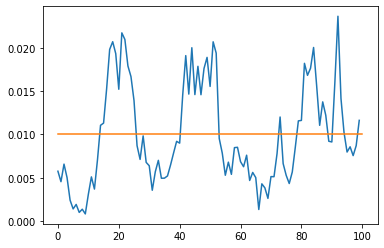

In [77]:
nframes=100
weights=my_dependent_dirichlet(nframes,1,100)

av_weights=np.mean(weights,axis=0)
print(av_weights.shape)

plt.plot(av_weights)
value=np.array([1/nframes,1/nframes])
plt.plot([0,len(av_weights)],value)


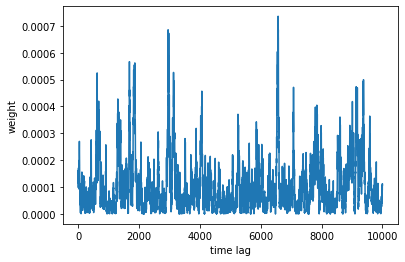

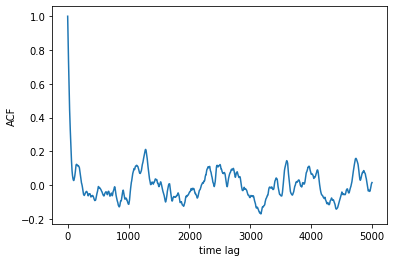

In [80]:
weights=my_dependent_dirichlet(10000,1,100).flatten()
#weights=av_weights
plt.plot(weights)
plt.xlabel("time lag")
plt.ylabel("weight")
plt.show()
plt.plot(autocorr(weights))
plt.xlabel("time lag")
plt.ylabel("ACF")
plt.show()

Makes sense!

## Estimating errors with dependent Dirichlet prior

I can now repeat the error analysis above using dependent Dirichlet prior.

Just to make a test, I run my calculation setting as autocorrelation time for the Dirichlet prior 100 steps (that, actually, is the same autocorrelation time of the original series).

In [18]:
skips=(1,2,5,10,20,50,100,200,500,1000,2000)
averages=[]
stddevs=[]
for skip in skips:
    # construct skipped timeseries
    s=series[::skip]
    # sample 200 times from weights according to the dirichlet distribution
    weights=my_dependent_dirichlet(len(s),size=200,tau=100/skip)
    # compute stddev of the result
    stddev=np.std(np.matmul(weights,s))
    # for comparison, we also compute the average along the skipped timeseries
    average=np.average(s)
    averages.append(average)
    stddevs.append(stddev)

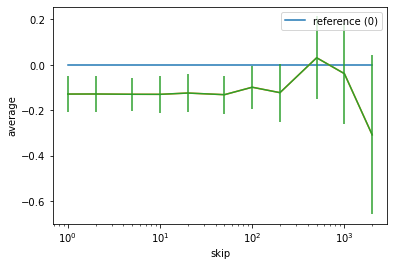

In [19]:
plt.plot(skips,np.zeros(len(skips)),label="reference (0)")
plt.plot(skips,averages)
plt.errorbar(skips,averages,stddevs)
plt.xscale("log")
plt.xlabel("skip")
plt.ylabel("average")
plt.legend()
plt.show()

This is much better:
- for large skip, samples are truly independent. My estimate becomes poor, and my estimated error large
- for small skip, samples are not independent but the prior knows this. Estimated error is compatible with the real error

I can now focus on the original trajectory (no skip) and make a scan over the value of tau for the Dirichlet prior.

In [20]:
stddevs=[]
taus=(1,2,5,10,20,50,100,200,500,1000,2000,5000)
for tau in taus:
    weights=my_dependent_dirichlet(N=len(series),size=200,tau=tau)
    # compute stddev of the result
    stddev=np.std(np.matmul(weights,series))
    stddevs.append(stddev)

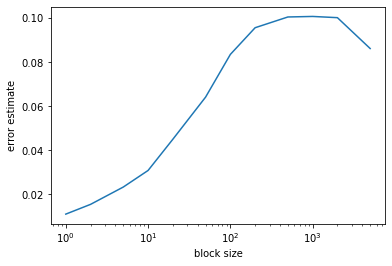

In [21]:
plt.plot(taus,stddevs)
plt.xscale("log")
plt.xlabel("block size")
plt.ylabel("error estimate")
plt.show()

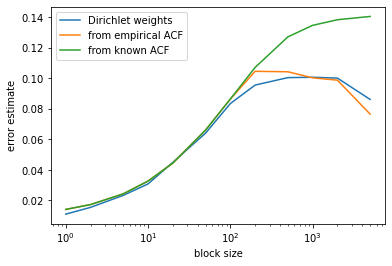

In [22]:
ac=autocorr(series)
errors1=[]
errors2=[]
for block_size in block_sizes:
    error1=np.sqrt(2/len(series)*np.sum(ac[:block_size]*(1-np.arange(block_size)/block_size)))
    errors1.append(error1)
    error2=np.sqrt(2/len(series)*np.sum(np.exp(-np.arange(block_size)/100)*(1-np.arange(block_size)/block_size)))
    errors2.append(error2)
plt.plot(taus,stddevs,label="Dirichlet weights")
plt.plot(block_sizes,errors1,label="from empirical ACF")
plt.plot(block_sizes,errors2,label="from known ACF")
plt.xscale("log")
plt.xlabel("block size")
plt.ylabel("error estimate")
plt.legend()
plt.show()

The result is virtually identical to the one predicted from the series ACF!

Notice that, as block analysis, the error estimate should have a plateau if I use longer trajectories.

## Test with longer trajectory

In [23]:
np.random.seed(1977)
series_long=autocorrelated_series(100000,100.0)

In [24]:
stddevs=[]
taus=(1,2,5,10,20,50,100,200,500,1000,2000,5000,10000,20000,50000)
for tau in taus:
    weights=my_dependent_dirichlet(N=len(series_long),size=200,tau=tau)
    # compute stddev of the result
    stddev=np.std(np.matmul(weights,series_long))
    stddevs.append(stddev)

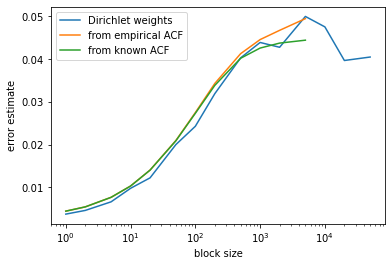

In [25]:
ac=autocorr(series_long)
errors1=[]
errors2=[]
for block_size in block_sizes:
    error1=np.sqrt(2/len(series_long)*np.sum(ac[:block_size]*(1-np.arange(block_size)/block_size)))
    errors1.append(error1)
    error2=np.sqrt(2/len(series_long)*np.sum(np.exp(-np.arange(block_size)/100)*(1-np.arange(block_size)/block_size)))
    errors2.append(error2)
plt.plot(taus,stddevs,label="Dirichlet weights")
plt.plot(block_sizes,errors1,label="from empirical ACF")
plt.plot(block_sizes,errors2,label="from known ACF")
plt.xscale("log")
plt.xlabel("block size")
plt.ylabel("error estimate")
plt.legend()
plt.show()

## Summary

- If I generate weights from a Dirichlet distribution and assume snapshots are independent, I underestimate the error due to correlations
- With block analysis I get a reasonable error estimate instead.
- (not shown but we know it:) If I first to blocks, then analyze blocks using bootstrap (or Bayesian bootstrap), I get an error estimate identical to standard block analysis with the error-of-the-mean formula as done above.
- If I generage weights from a dependent Dirichlet distribution with a large enough correlation time, I also get a reasonable error estimate.
